<h1>Analysis and Plotting of UK house prices</h1>
* _fun way to get started with pandas_
* _as well as plotting libraries seaborn and cartopy_

<h3>Load data into pandas dataframe and inspect the data</h3>

**Import the required python libraries**

In [1]:
# import the required libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import time
import calendar
import seaborn as sns
from scipy import stats

** Get the purchase price data for 2016 from Land Registry**

In [2]:
# get the purchase price data, obviously this step is required only once
#!wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2016.csv

**Read the csv file into pandas dataframe, the data has no header so colnames adds column headers**

In [3]:
# read the csv file into pandas dataframe, the data has no header so colnames adds column headers
colnames = ['tid','price','dateoftransfer','postcode','type','age','duration','PAON','SAON','street','locality','town','district','county','ttype','tstatus']
hp_df = pd.read_csv('./uk-houseprice-analysis/pp-2016.csv', names=colnames, parse_dates=True, dayfirst = True)

**Inspect the data**

In [4]:
# inspect the data in pandas dataframe
hp_df.head(3)

tid   price    dateoftransfer  postcode  \
0  {3B7E0B8F-7987-EA99-E050-A8C062057E77}  338000  2016-08-10 00:00  MK44 2EL   
1  {3B7E0B8F-7988-EA99-E050-A8C062057E77}  245000  2016-07-15 00:00   LU6 1LU   
2  {3B7E0B8F-7989-EA99-E050-A8C062057E77}  275000  2016-07-26 00:00   LU6 1RF   

  type age duration               PAON SAON          street    locality  \
0    D   N        F  LABURNHAM COTTAGE  NaN  KIMBOLTON ROAD   BOLNHURST   
1    T   N        F                 51  NaN    CLIFTON ROAD         NaN   
2    T   N        F                  3  NaN    CHURCH GREEN  TOTTERNHOE   

        town              district                county ttype tstatus  
0    BEDFORD               BEDFORD               BEDFORD     A       A  
1  DUNSTABLE  CENTRAL BEDFORDSHIRE  CENTRAL BEDFORDSHIRE     A       A  
2  DUNSTABLE  CENTRAL BEDFORDSHIRE  CENTRAL BEDFORDSHIRE     A       A

In [5]:
# length of the pandas dataframe
print "Number of records in the dataframe -", len(hp_df)
# show the stastical summary of the data
pd.options.display.float_format = '{:20,.2f}'.format
hp_df.describe()
#hp_df.dtypes

Number of records in the dataframe - 971782


price
count           971,782.00
mean            305,878.30
std             799,058.46
min                   1.00
25%             136,500.00
50%             213,000.00
75%             335,000.00
max          96,840,522.00

In [6]:
# unique values for a particular column
hp_df.town.unique()

array(['BEDFORD', 'DUNSTABLE', 'RUSHDEN', ..., 'LLANBEDRGOCH',
       'LLANSANTFFRAID', 'DULAS'], dtype=object)

**Download the postcode to lat/long mapping data**,
_this is required for plotting the house price data onto map_

In [7]:
# this data downloaded from http://ons.maps.arcgis.com/home/item.html?id=a26683d2393743f4b87c89141cd1b2e8
# applied the following transformation
# import pandas as pd
# df = pd.read_csv('./NSPL_FEB_2017_UK.csv')
# df[['pcds','lat','long']].to_csv('pc-lat-long.csv')

# read the postcode to lat/long mapping data into dataframe
# this is required to do some cool plotting
ll_df = pd.read_csv('./uk-houseprice-analysis/pc-lat-long.csv')

In [8]:
# inspect the postcode pandas dataframe
ll_df.tail()

id postcode                  lat                 long
2593608  2593608  ZE3 9JW                59.87                -1.31
2593609  2593609  ZE3 9JX                59.88                -1.31
2593610  2593610  ZE3 9JY                59.89                -1.31
2593611  2593611  ZE3 9JZ                59.89                -1.31
2593612  2593612  ZE3 9XP                59.89                -1.31

** Join the house price dataframe (hp_df) with latitute/longitude (ll_df) dataframe **

In [9]:
# join the house price dataframe (hp_df) with latitute/longitude (ll_df) dataframe
pl_df=pd.merge(hp_df, ll_df, how='left', on='postcode')
pl_df.head(3)

tid   price    dateoftransfer  postcode  \
0  {3B7E0B8F-7987-EA99-E050-A8C062057E77}  338000  2016-08-10 00:00  MK44 2EL   
1  {3B7E0B8F-7988-EA99-E050-A8C062057E77}  245000  2016-07-15 00:00   LU6 1LU   
2  {3B7E0B8F-7989-EA99-E050-A8C062057E77}  275000  2016-07-26 00:00   LU6 1RF   

  type age duration               PAON SAON          street    locality  \
0    D   N        F  LABURNHAM COTTAGE  NaN  KIMBOLTON ROAD   BOLNHURST   
1    T   N        F                 51  NaN    CLIFTON ROAD         NaN   
2    T   N        F                  3  NaN    CHURCH GREEN  TOTTERNHOE   

        town              district                county ttype tstatus  \
0    BEDFORD               BEDFORD               BEDFORD     A       A   
1  DUNSTABLE  CENTRAL BEDFORDSHIRE  CENTRAL BEDFORDSHIRE     A       A   
2  DUNSTABLE  CENTRAL BEDFORDSHIRE  CENTRAL BEDFORDSHIRE     A       A   

                    id                  lat                 long  
0         1,416,993.00                52.22                -0.41  
1         1,318,098.00                51.89                -0.53  
2         1,318,161.00                51.88                -0.56

In [10]:
# did we loose any records?
print len(hp_df) - len(pl_df)

0


**Do we have any nulls for lat/long**
* _likely reasons are either the postcode is null_
* _new build with new postcode where last/long is still not available_

In [11]:
# inspect the records where lat/long is null
# likely reason is either the postcode is null or a new build with new postcode where last/long is still not available 
pl_df[pl_df['long'].isnull()].head()

tid   price    dateoftransfer  \
800   {3914047A-36CE-3206-E050-A8C063057647}  280500  2016-07-22 00:00   
1376  {369DFB16-8377-3A19-E050-A8C0620518C6}  175000  2016-03-16 00:00   
1398  {369DFB16-85AF-3A19-E050-A8C0620518C6}   80972  2016-04-29 00:00   
1399  {369DFB16-85B0-3A19-E050-A8C0620518C6}   80972  2016-04-29 00:00   
1769  {369DFB16-8A2E-3A19-E050-A8C0620518C6}  120000  2016-02-18 00:00   

     postcode type age duration                              PAON    SAON  \
800       NaN    D   N        F         UNDERBANK RESERVOIR HOUSE     NaN   
1376      NaN    O   N        F  BOVINGDON SEWAGE TREATMENT WORKS     NaN   
1398      NaN    S   Y        F                           PLOT A7     NaN   
1399      NaN    S   Y        F                           PLOT A8     NaN   
1769      NaN    O   N        F               RHINO BUSINESS PARK  UNIT C   

               street      locality             town            district  \
800   MANCHESTER ROAD  STOCKSBRIDGE        SHEFFIELD           SHEFFIELD   
1376    SHANTOCK LANE     BOVINGDON  HEMEL HEMPSTEAD             DACORUM   
1398  WESTBROOKE ROAD           NaN          LINCOLN             LINCOLN   
1399  WESTBROOKE ROAD           NaN          LINCOLN             LINCOLN   
1769       FAULD LANE       TUTBURY  BURTON-ON-TRENT  EAST STAFFORDSHIRE   

               county ttype tstatus                   id                  lat  \
800   SOUTH YORKSHIRE     A       A                  nan                  nan   
1376    HERTFORDSHIRE     B       A                  nan                  nan   
1398     LINCOLNSHIRE     B       A                  nan                  nan   
1399     LINCOLNSHIRE     B       A                  nan                  nan   
1769    STAFFORDSHIRE     B       A                  nan                  nan   

                     long  
800                   nan  
1376                  nan  
1398                  nan  
1399                  nan  
1769                  nan

<h3>Lets do some analysis with the purchase price data</h3>
* _univariate and multivariate analysis_
* _aggregations_

**2016 Purchase price histogram**

Number of outliers, purchase price > 10m -  719


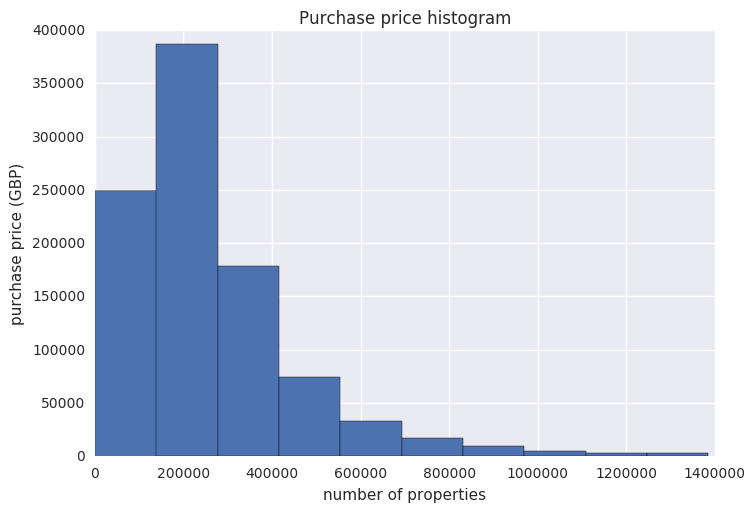

In [12]:
# histogram by purchase price after removing the outliers (price > 10millon)
print "Number of outliers, purchase price > 10m - ",len(pl_df[pl_df['price']>10000000])
hst_df = pl_df[pl_df['price']<=10000000]
ax = hst_df[(np.abs(stats.zscore(hst_df['price'])) < 3)]['price'].hist(bins=10)
ax.set_title("Purchase price histogram")
ax.set_xlabel("number of properties")
ax.set_ylabel("purchase price (GBP)")

**Number of properties sold per month in 2016**

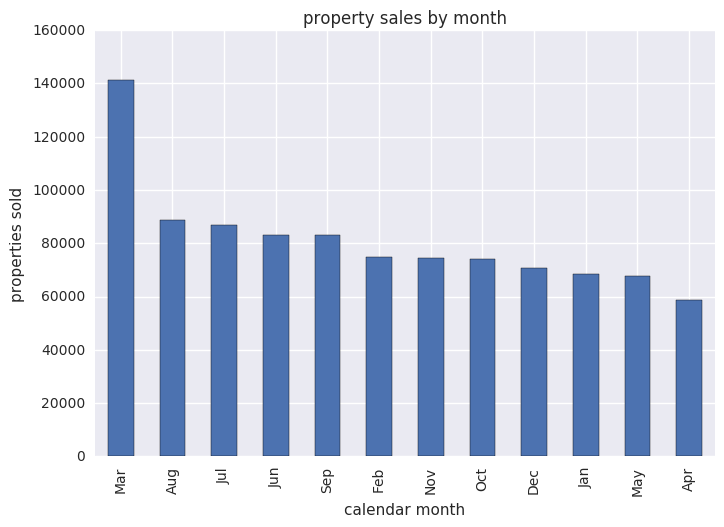

In [13]:
# property sales by month
#plt.figure(figsize=(10,5))
ax = hp_df['dateoftransfer'].str[5:7].astype(int).map(lambda x: calendar.month_abbr[x]).value_counts().plot(x='dateoftransfer', kind='bar', title="property sales by month")
ax.set_xlabel("calendar month")
ax.set_ylabel("properties sold")

**Heatmap of property sales in london districts in each month**

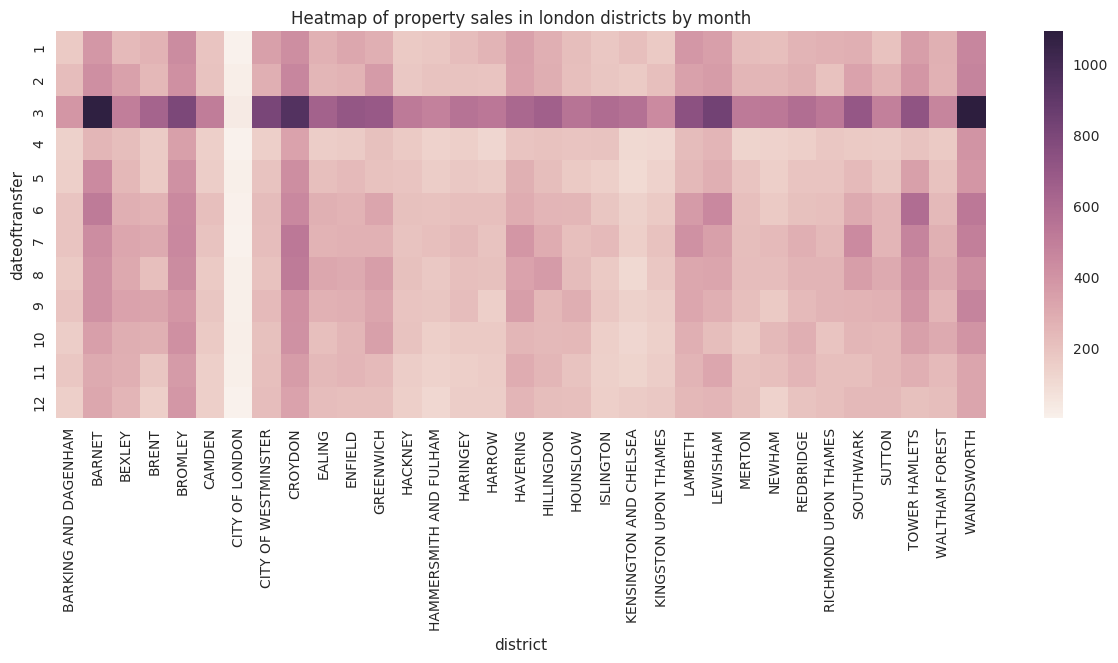

In [14]:
# heatmap of sales in london district in each month
ldn_df=hp_df[hp_df['county']=='GREATER LONDON'].groupby([hp_df['dateoftransfer'].str[5:7].astype(int),hp_df['district']]).size().rename('counts').reset_index()
plt.figure(figsize=(15, 5))
ax = sns.heatmap(ldn_df.pivot(index='dateoftransfer', columns='district', values='counts'))
ax.set_title("Heatmap of property sales in london districts by month")

**Heatmap of total purchase price in london districts in each month**

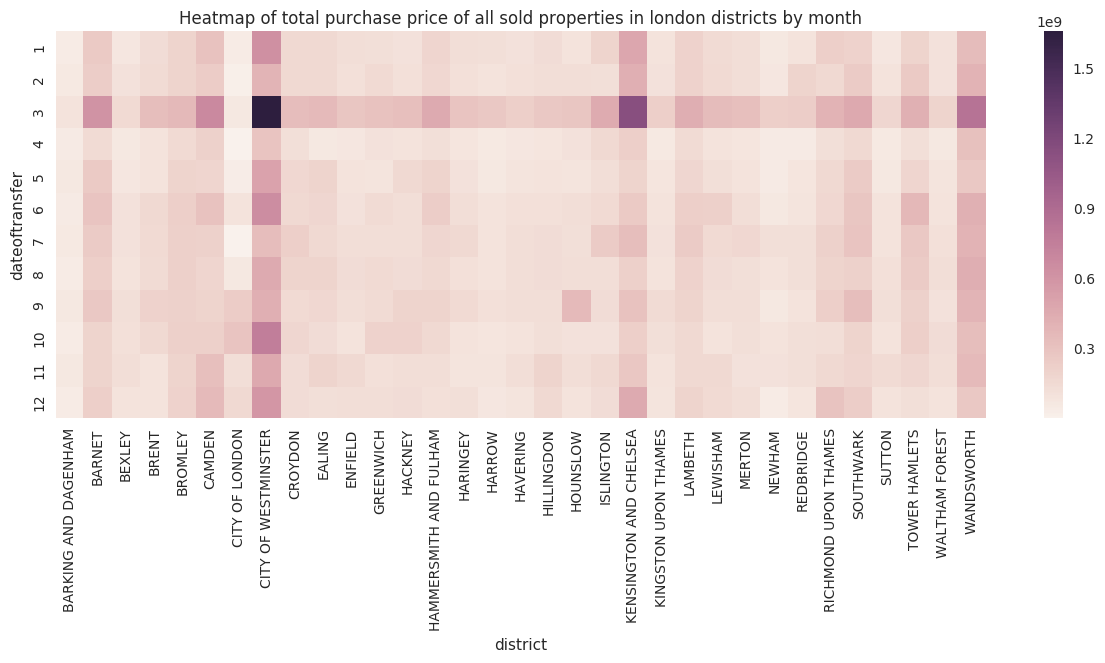

In [15]:
# heatmap of total purchase price in london district in each month
lv_df=hp_df[hp_df['county']=='GREATER LONDON'].groupby([hp_df['dateoftransfer'].str[5:7].astype(int),hp_df['district']]).agg({'price':sum}).reset_index()
plt.figure(figsize=(15, 5))
ax = sns.heatmap(lv_df.pivot(index='dateoftransfer', columns='district', values='price'))
ax.set_title("Heatmap of total purchase price of all sold properties in london districts by month")

**Evolution of average purchase price in Leeds**

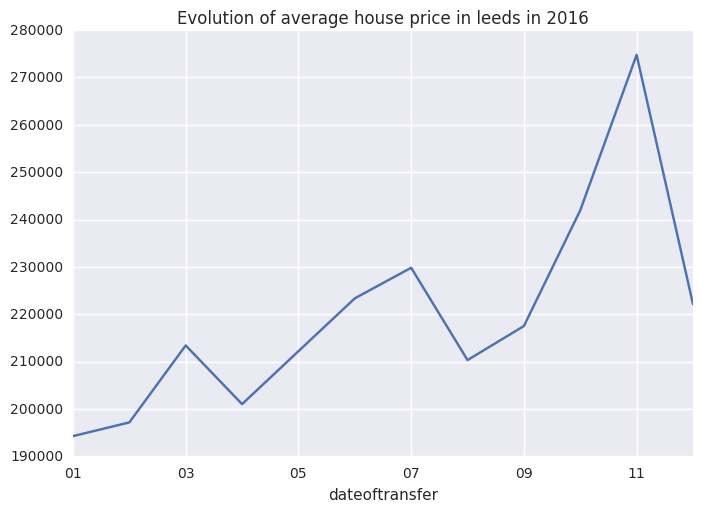

In [16]:
# Average house price in leeds over 2016
ax = hp_df[hp_df['town'] == "LEEDS"].groupby(hp_df['dateoftransfer'].str[5:7])['price'].mean().plot()
ax.set_title("Evolution of average house price in leeds in 2016")

**Average house prices by GREATER LONDON districts in 2016**

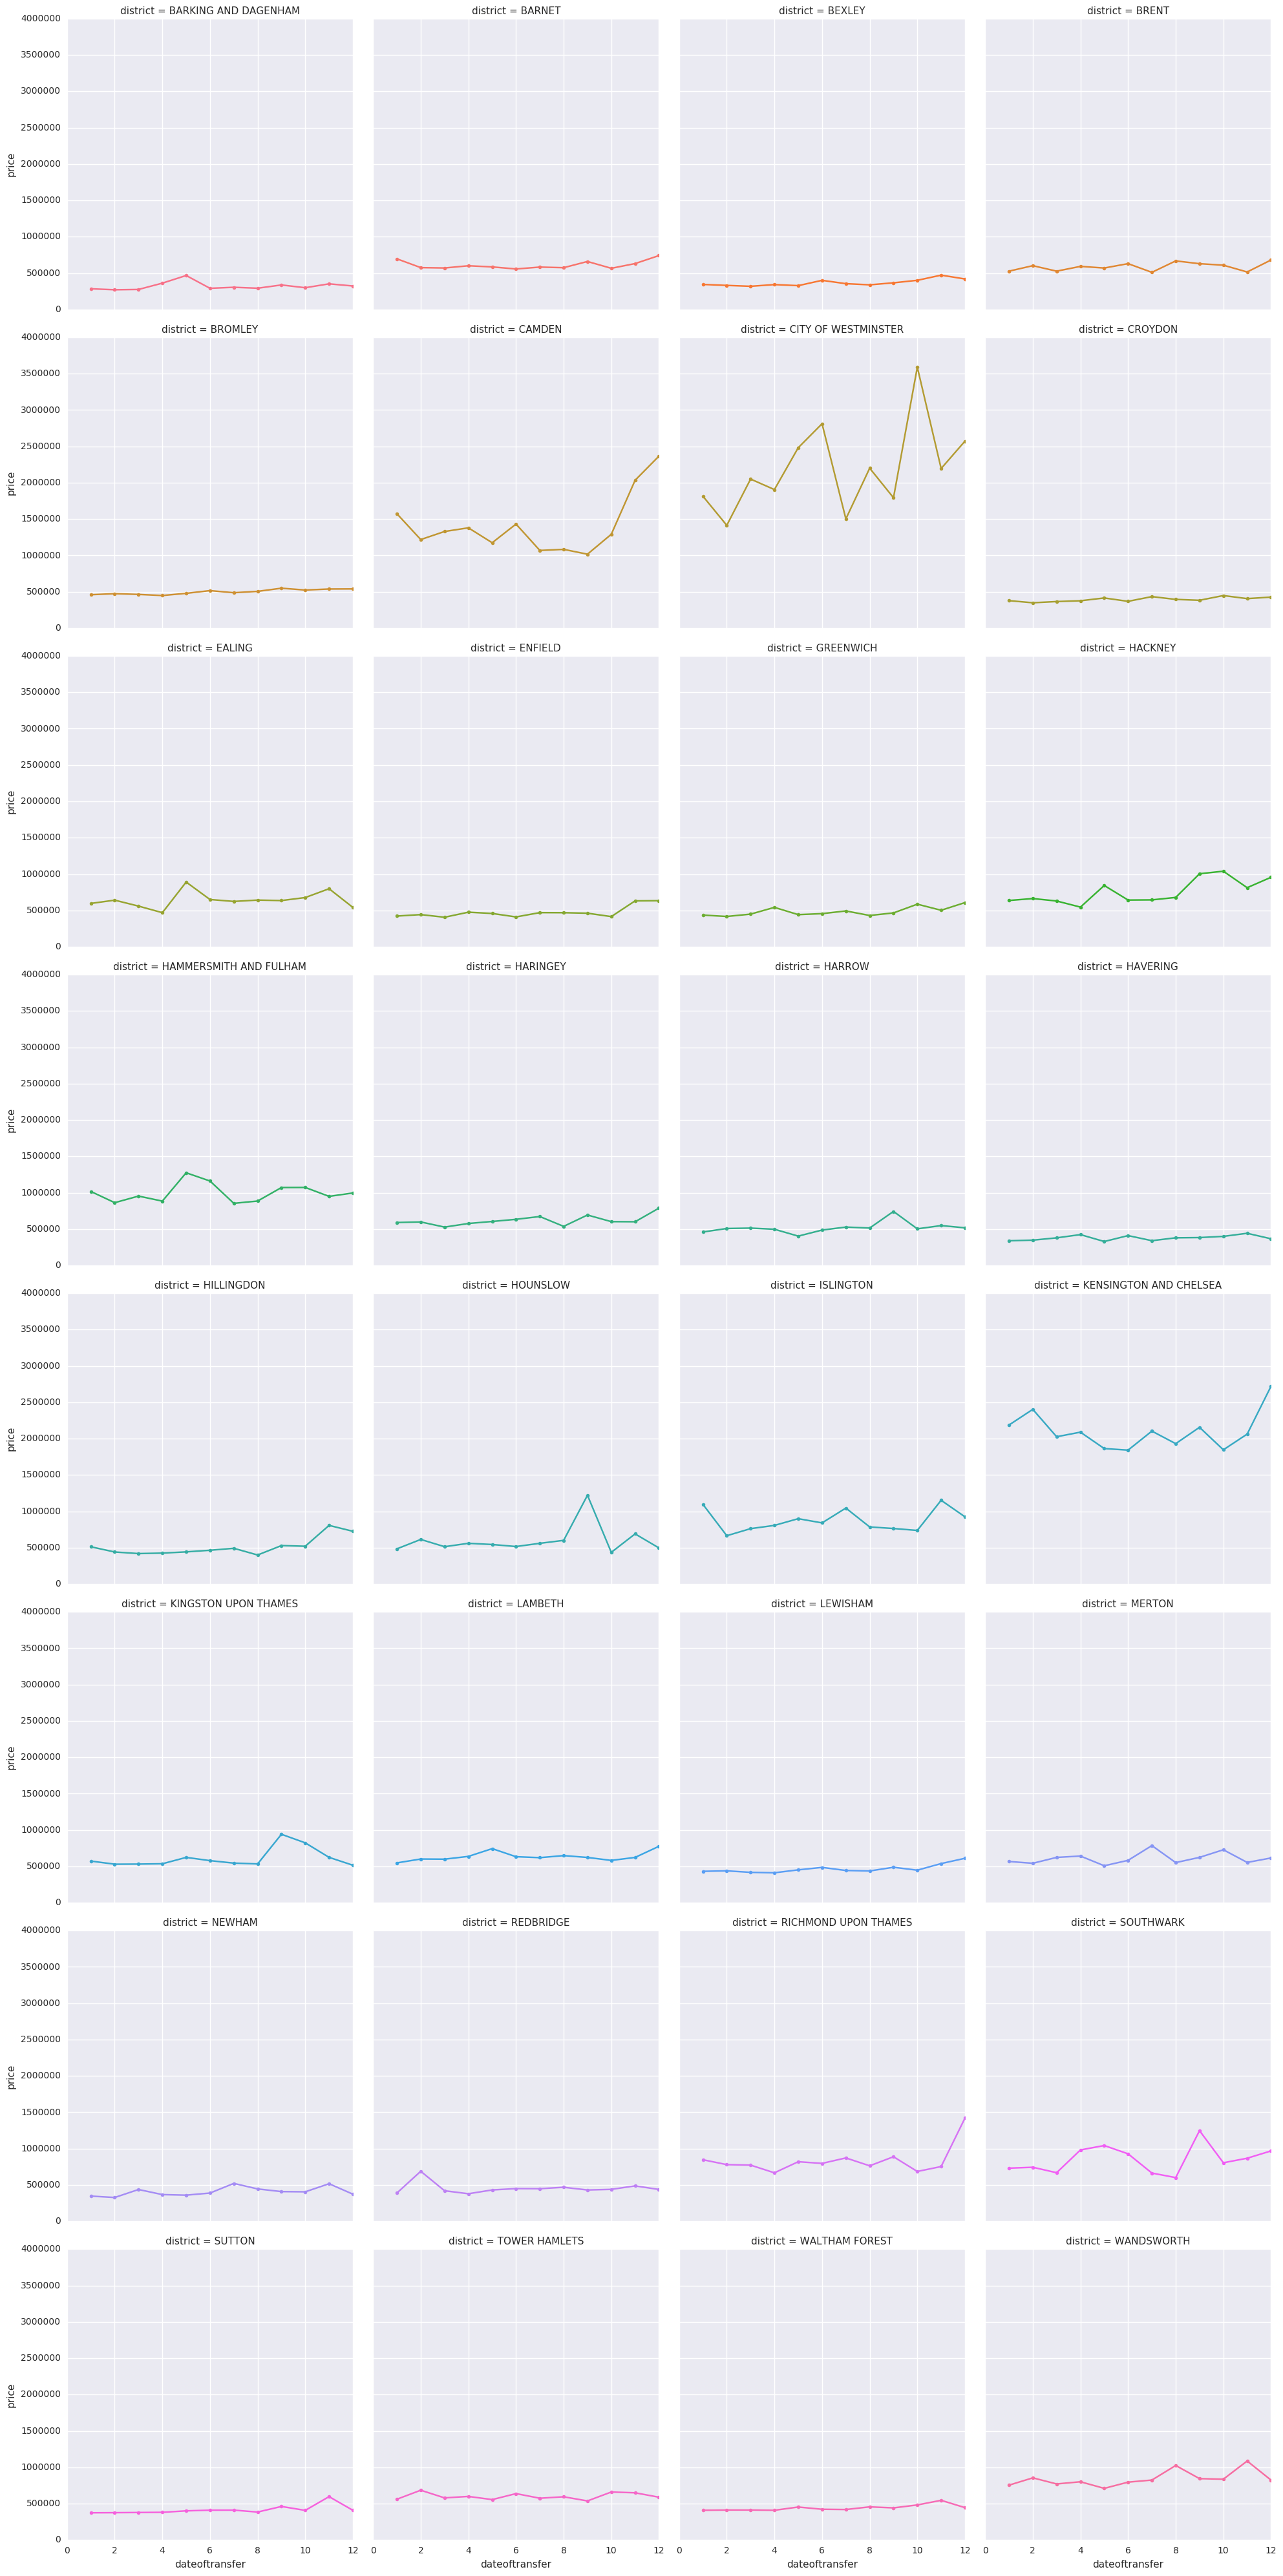

In [17]:
# Average house prices by greater london districts in 2016, this produces a grid of plots using seborn facets
grid_df = hp_df[(hp_df.county=='GREATER LONDON') & (hp_df.district!='CITY OF LONDON')].groupby([hp_df['dateoftransfer'].str[5:7],hp_df['district']])['price'].mean().reset_index()
grid = sns.FacetGrid(grid_df, col="district", hue="district", col_wrap=4, size=5)
grid.map(plt.plot, "dateoftransfer", "price", marker="o", ms=4)

**Number of houses sold by property type in 2016**

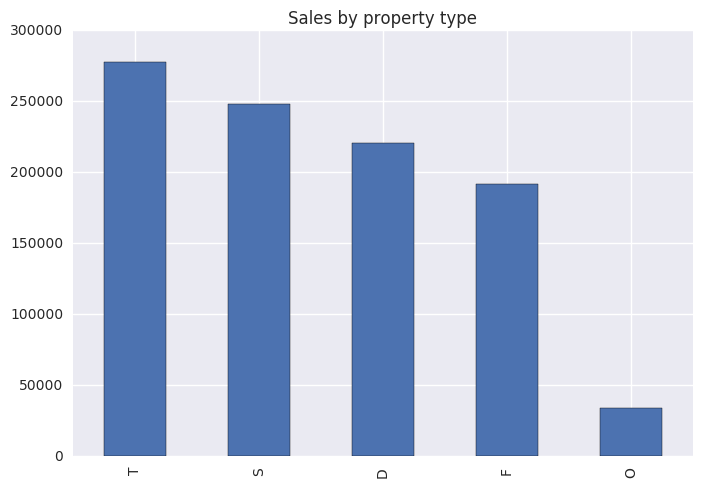

In [18]:
# number of houses sold by type
ax = hp_df["type"].value_counts().plot(x='type', kind='bar')
ax.set_title("Sales by property type")

**Distribution of newbuilds across country**

/afs/cern.ch/user/p/pkothuri/public/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


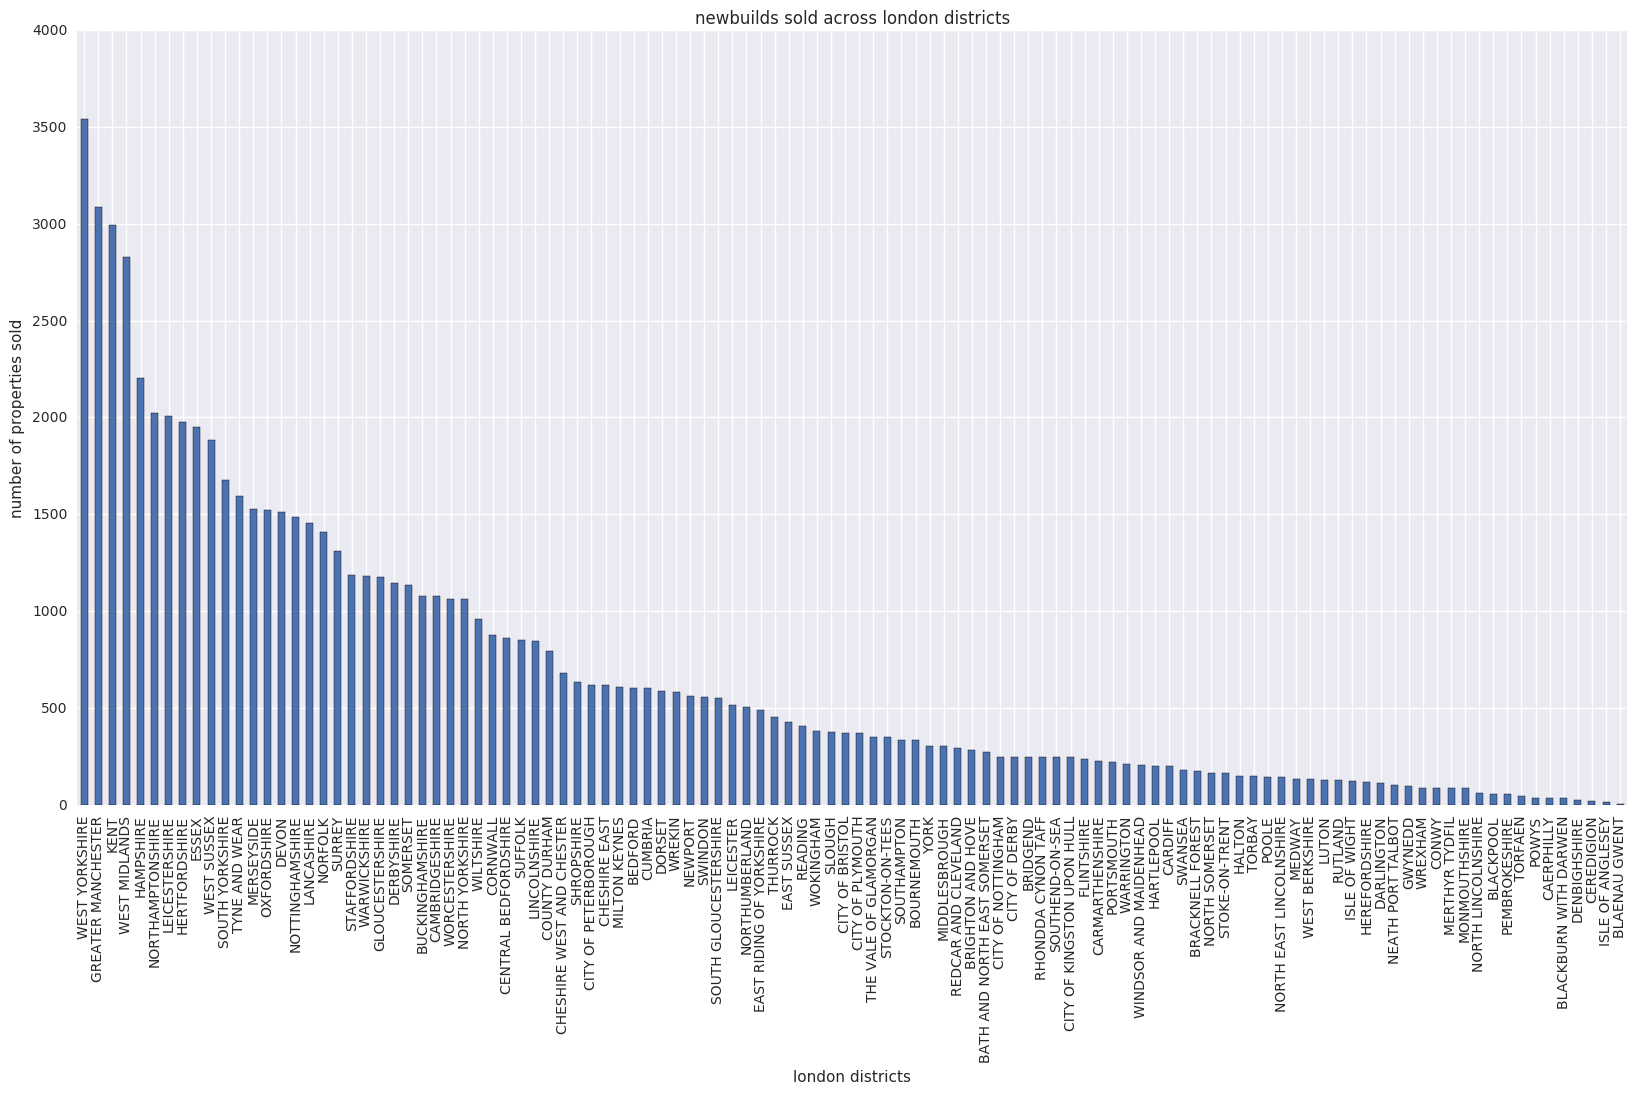

In [19]:
# distribution of newbuilds across country
ax = hp_df[hp_df.county!='GREATER LONDON'][hp_df.age == 'Y']["county"].value_counts().plot(x='county', kind='bar', figsize=(20,10))
ax.set_title("newbuilds sold across london districts")
ax.set_xlabel("london districts")
ax.set_ylabel("number of properties sold")

**House price distribution by locality in Leeds**

/afs/cern.ch/user/p/pkothuri/public/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


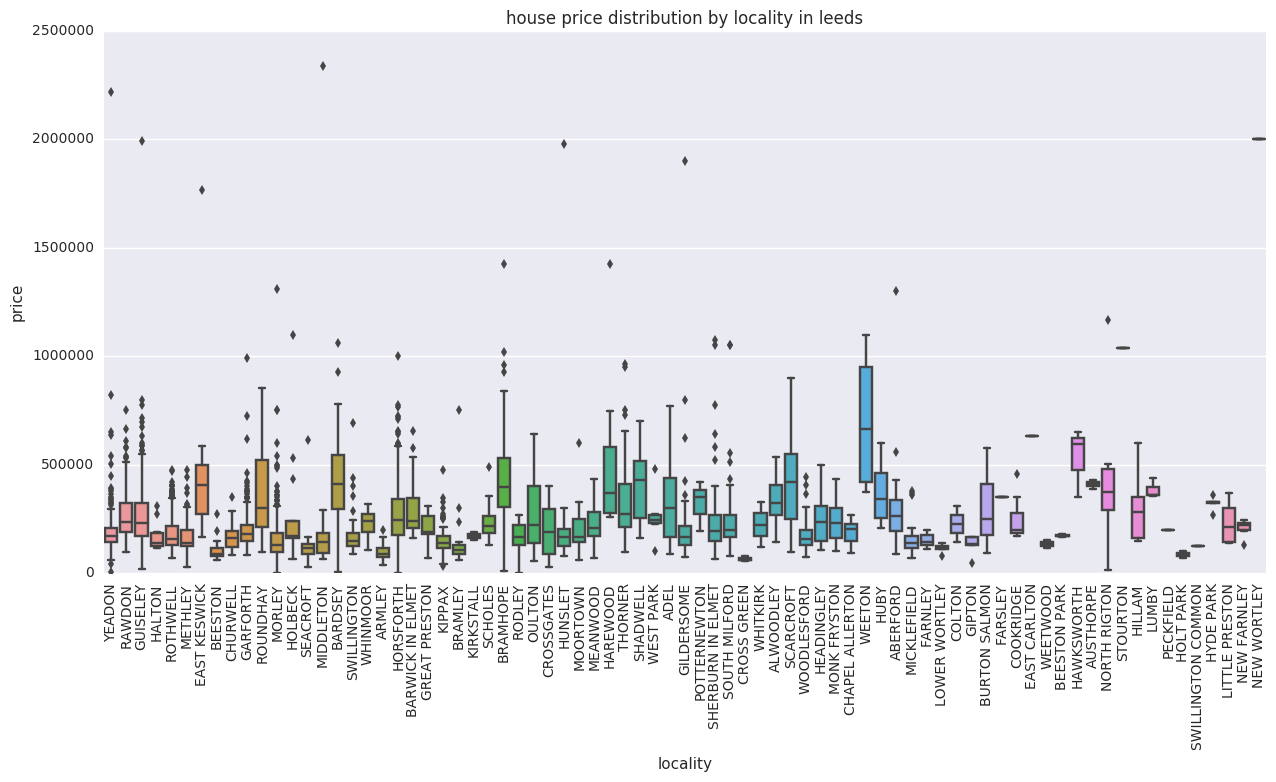

In [20]:
# house price distribution by locality in Leeds (change the town as per your needs)
bx_df = hp_df[hp_df.town=='LEEDS'][np.abs(hp_df.price-hp_df.price.mean())<=(3*hp_df.price.std())][['locality','price']]
plt.figure(figsize=(15, 7))
ax=sns.boxplot(x='locality', y='price', data=bx_df)
ax_txt = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_title("house price distribution by locality in leeds")

<h3>mapping the house price data</h3>
* _yes its possible to obtain lat/long based on postcode_

**Plot the geo location of house sales, red dots represent newbuilds and blue dots represent the rest**

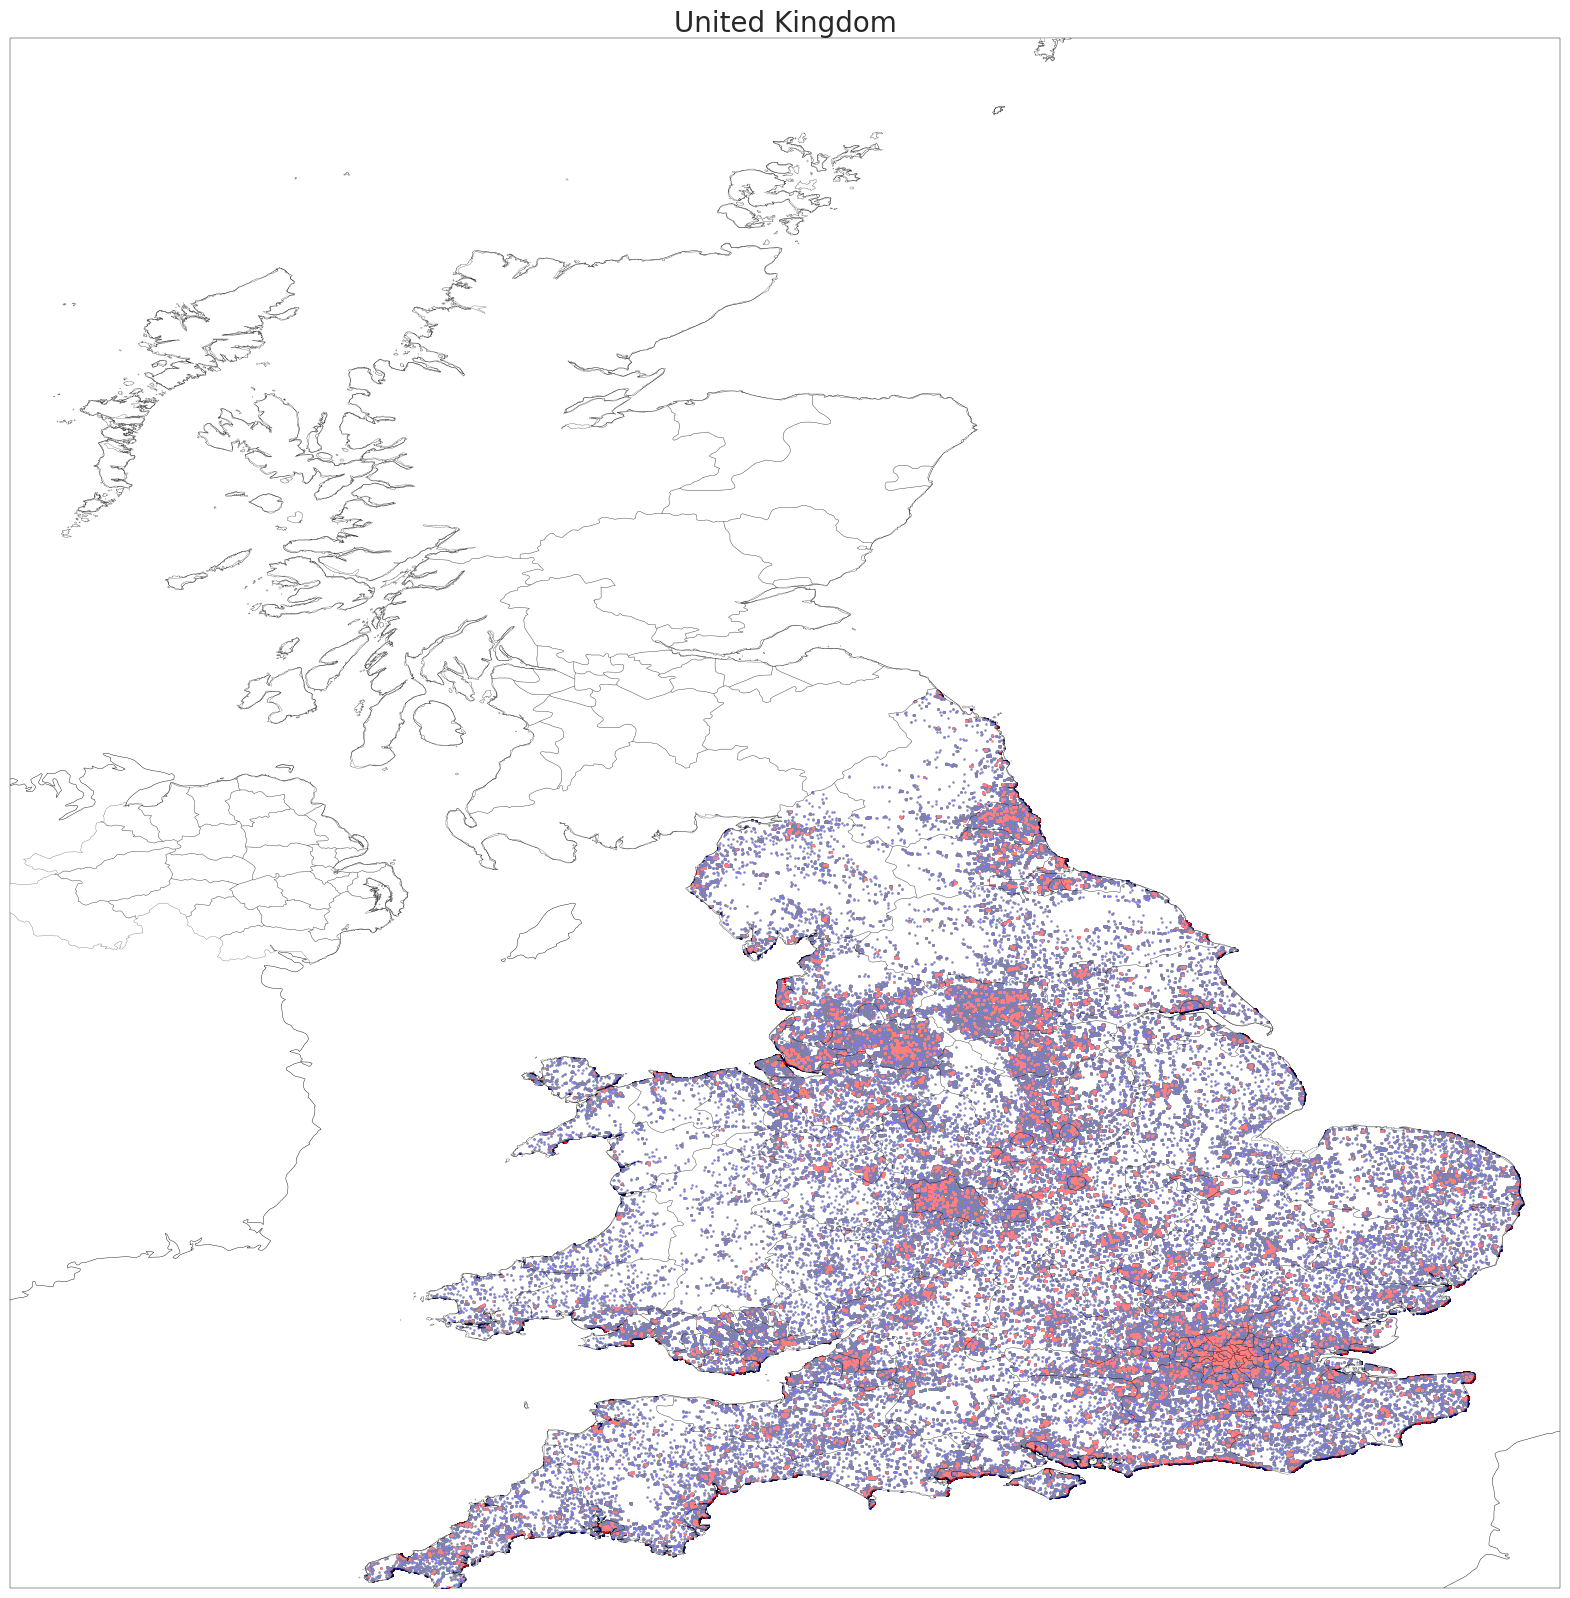

In [21]:
# plot the house sales info on the map

# import the required packages
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize=(20, 20))

# select the required projection
ax = plt.axes(projection=ccrs.PlateCarree())

# draw the required rectagle/polygon
# (x1,y1) -> (x2,y2)
# remember x-axis is longitude and y-axis is latitude
ax.set_extent([-8, 2, 50, 60], ccrs.PlateCarree())

# get and plot geometry from shape files
# you download the shapefile for countries from global administrative areas website (http://www.gadm.org/country)
fname = './uk-houseprice-analysis/shape/GBR_adm2.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),edgecolor='black', facecolor='white', alpha=0.5,zorder=10)
ax.coastlines(resolution='10m')

# plot the house price data onto the map, red dots for newbuilds and blue dots for others
ax.scatter(pl_df[pl_df['age'] == 'N']['long'],pl_df[pl_df['age'] == 'N']['lat'],s=2, marker='o',transform=ccrs.PlateCarree())
ax.scatter(pl_df[pl_df['age'] == 'Y']['long'],pl_df[pl_df['age'] == 'Y']['lat'],color='red',s=2, marker='o',transform=ccrs.PlateCarree())

# set the title and show the plot
ax.set_title('United Kingdom',fontsize=20)
plt.show()

**Plot the house sales data for a particular town (e.g LEEDS) using Stamen Toner**

**dots are color coded, PURPLE = affordable, RED = expensive**

**Which part of LEEDS is expensive?**

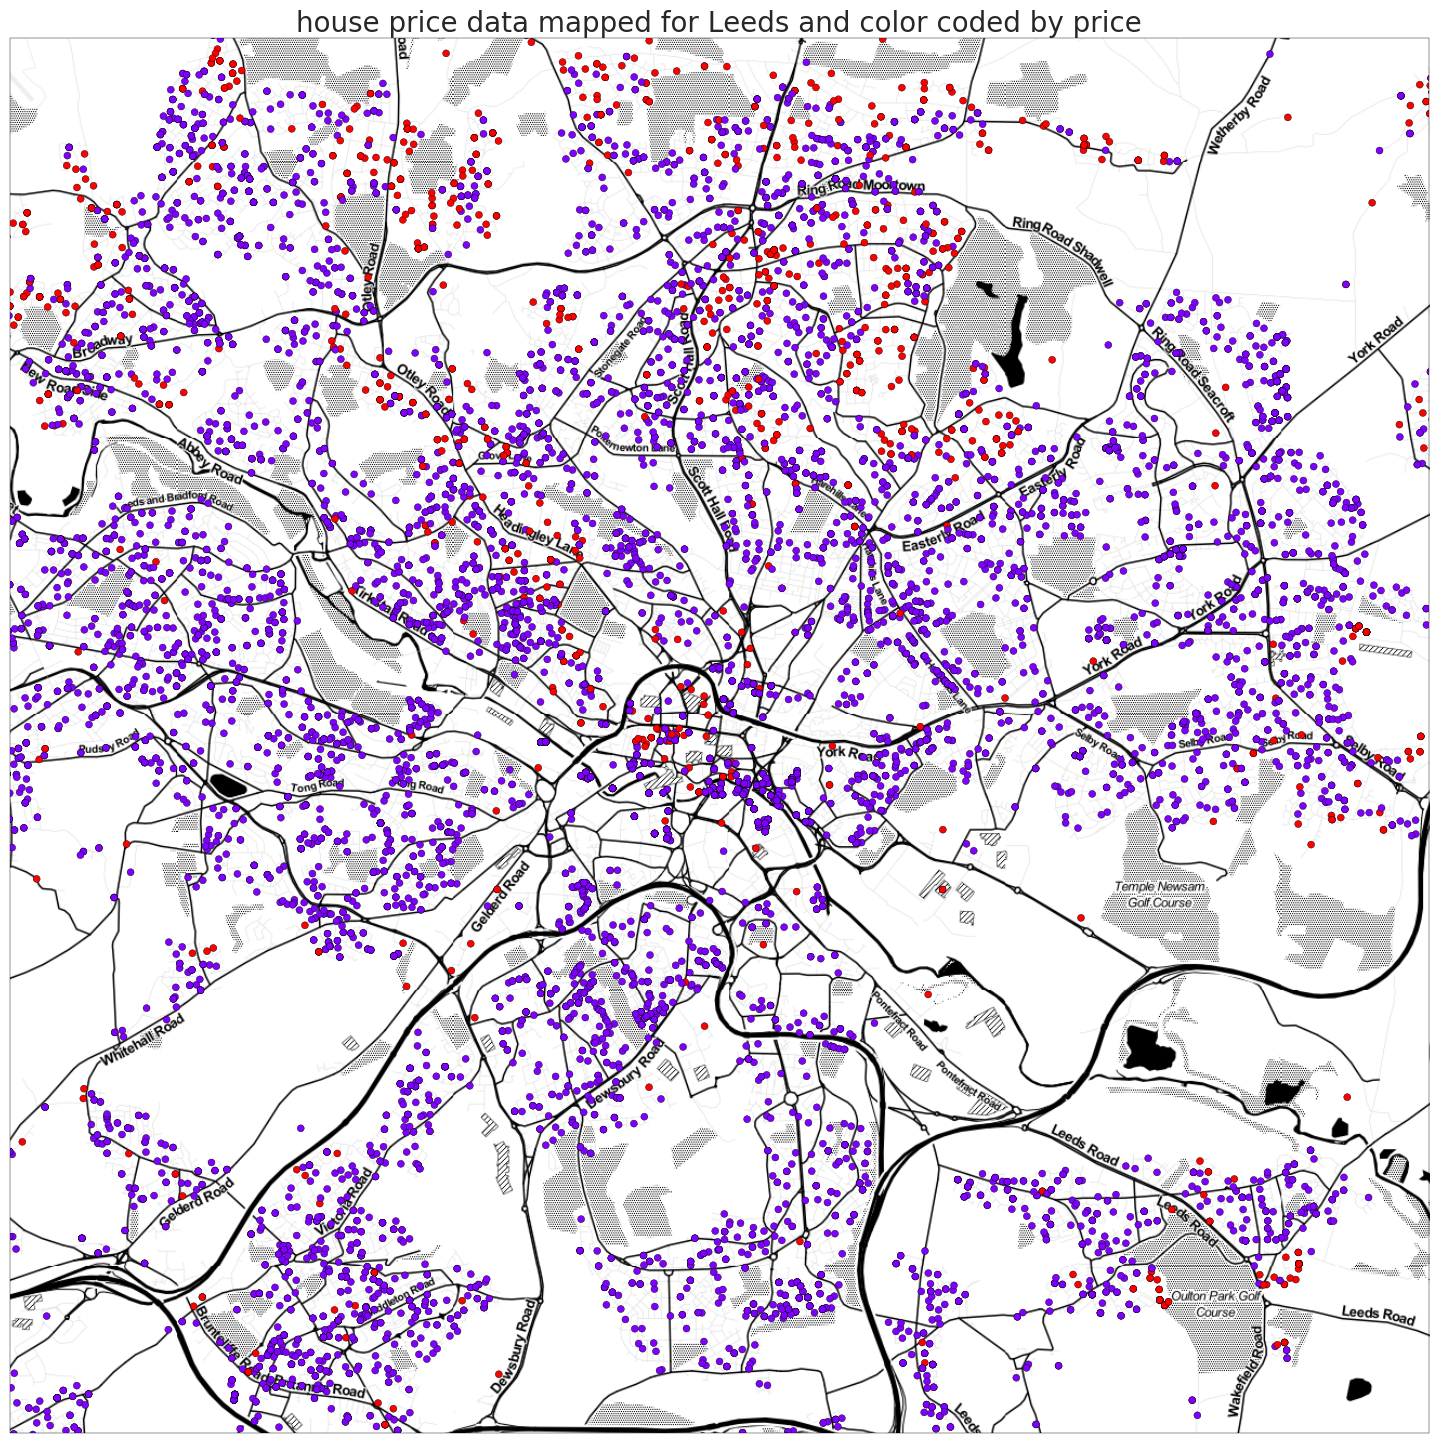

In [22]:
# this time lets try to plot the house sales data for a particular town using Stamen Toner
# I use stamen toner as its nicely crafted with enough information like street names

# import and function to get an handle on stamen toner imagery
from cartopy.io.img_tiles import GoogleTiles
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/toner/{}/{}/{}.png'.format(z, x, y)
        return url

# select the required projection
plt.figure(figsize=(20, 18))
imagery=StamenToner()
ax = plt.axes(projection=imagery.crs)

# set the extent of the required polygon
# (x1,y1) to (x2,y2), remember x-axis is longitude and y-axis is latitude
ax.set_extent([-1.652584,-1.426678, 53.733076, 53.864271],ccrs.PlateCarree())

# add the imagery at the required zoom levels
# OSM zoom levels are here - http://wiki.openstreetmap.org/wiki/Zoom_levels
ax.add_image(imagery, 13)
colors = pd.Series(pl_df['price']//300000)
colors[colors>1]=1

# plot the data
ax.scatter(pl_df['long'],pl_df['lat'],c=colors,s=25,cmap=cm.rainbow,transform=ccrs.PlateCarree())
ax.coastlines('10m')
ax.set_title('house price data mapped for Leeds and color coded by price',fontsize=20)
plt.show()

In [23]:
# number of millionaire homes in UK
ml_df = pl_df[pl_df.price >= 1000000]
print "millionaire homes in United Kingdom - ",len(ml_df)

millionaire homes in United Kingdom -  21576


**Plot the millionaire home in UK**

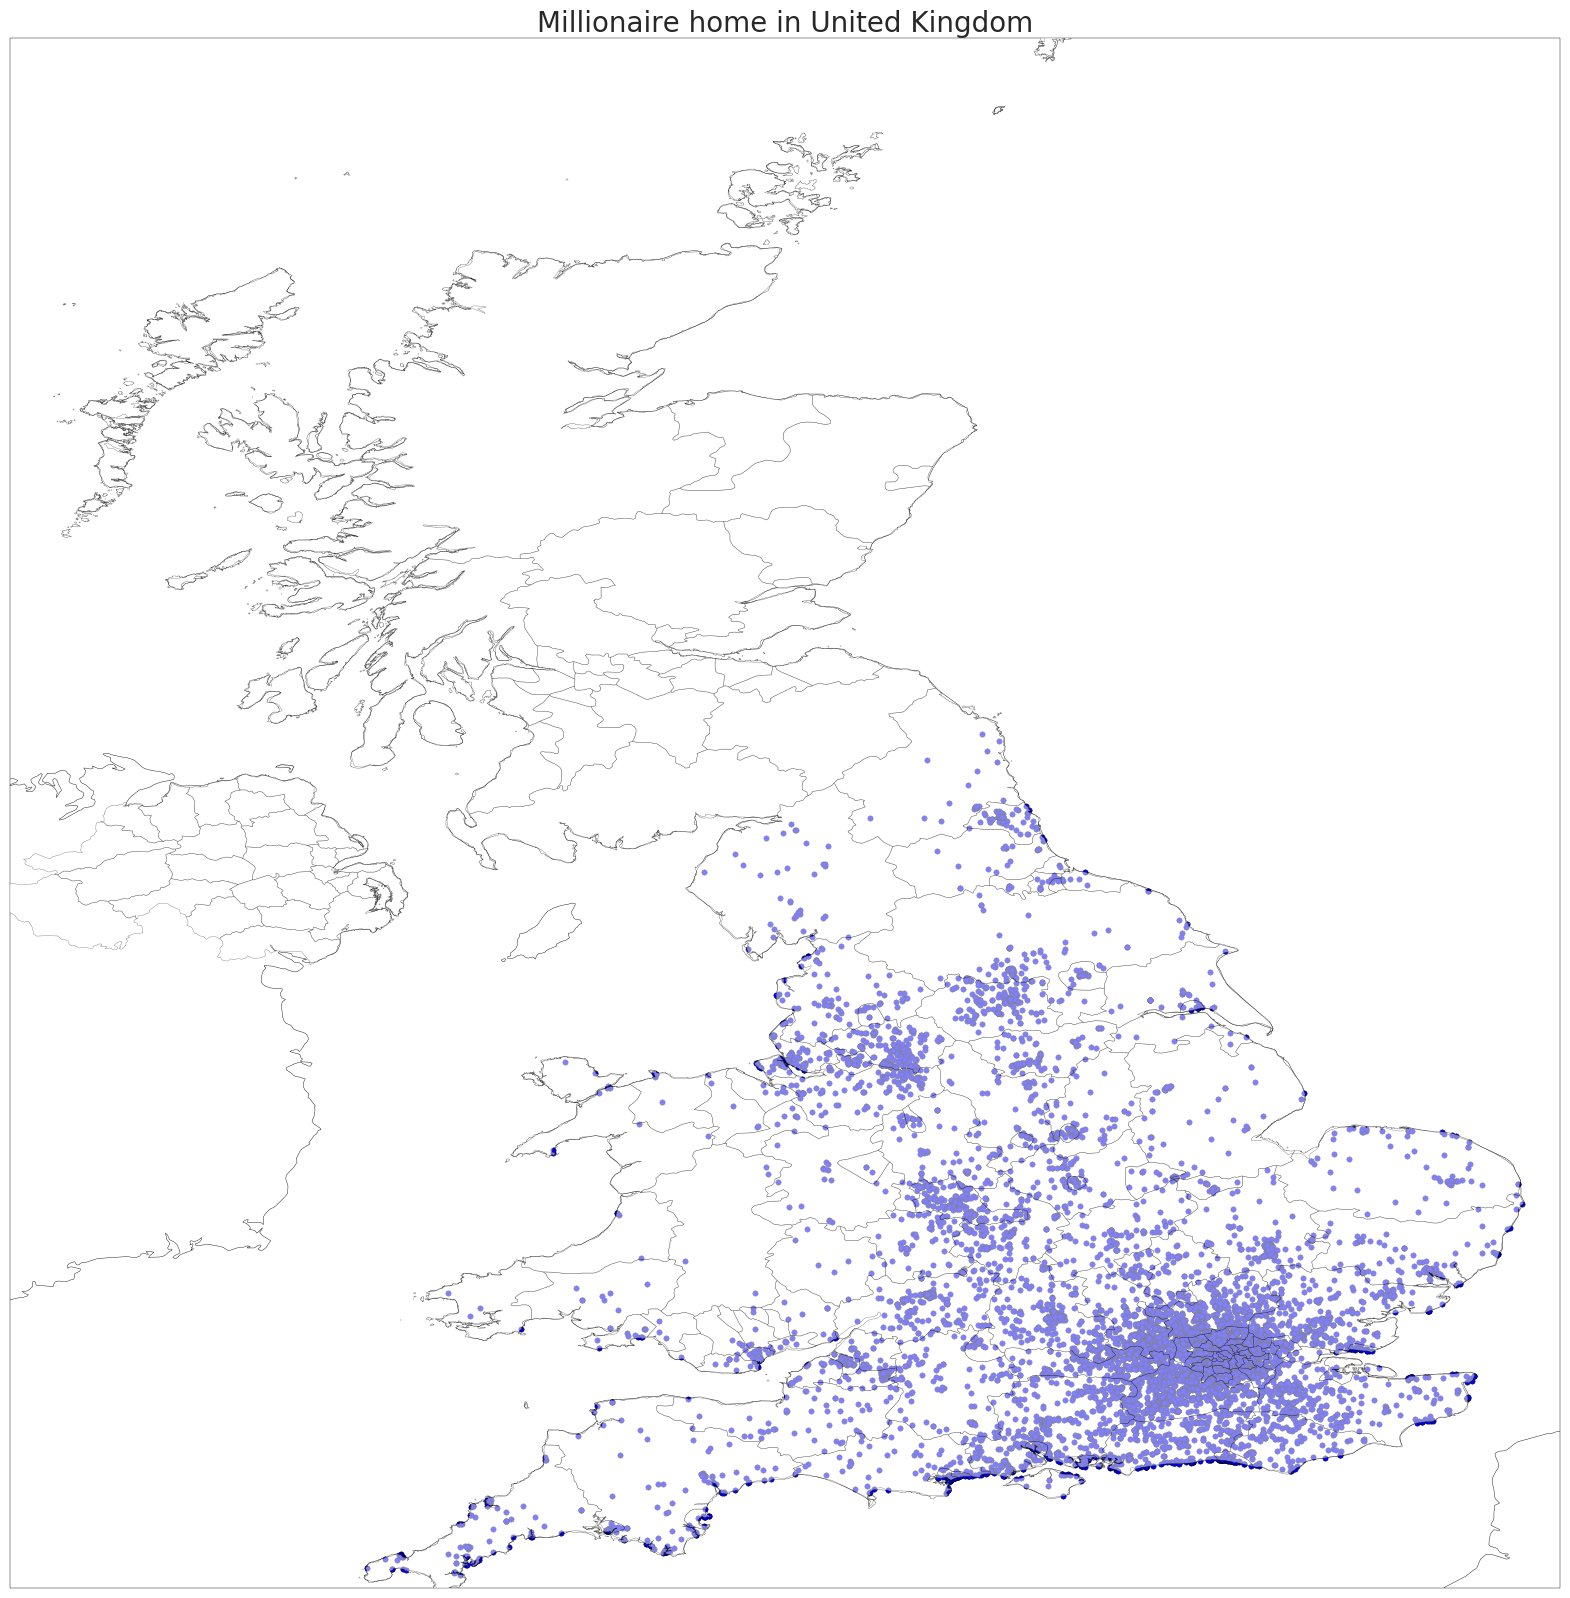

In [24]:
# millionaire homes in UK!!
fig = plt.figure(figsize=(20, 20))

# select the required projection
ax = plt.axes(projection=ccrs.PlateCarree())

# draw the required rectagle/polygon
# (x1,y1) -> (x2,y2)
# remember x-axis is longitude and y-axis is latitude
ax.set_extent([-8, 2, 50, 60], ccrs.PlateCarree())

# get and plot geometry from shape files
# you download the shapefile for countries from global administrative areas website (http://www.gadm.org/country)
fname = './uk-houseprice-analysis/shape/GBR_adm2.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),edgecolor='black', facecolor='white', alpha=0.5,zorder=10)
ax.coastlines(resolution='10m')

ml_df = pl_df[pl_df.price >= 1000000]
# plot the house price data onto the map, red dots for newbuilds and blue dots for others
ax.scatter(ml_df['long'],ml_df['lat'],s=15, marker='o',transform=ccrs.PlateCarree())
# set the title and show the plot
ax.set_title('Millionaire home in United Kingdom',fontsize=20)
plt.show()

In this notebook we analysed and visualised UK house price data using pandas, seaborn & cartopy. We are able to answer many questions like 1) Able to identify the expensive areas for a give city? 2) Where are the additional housing capacity (newbuilds) added? (e.g potential opportunity to open new businesses and provide additional services) 3) London districts where the prices are still affordable. 4) Areas where there are unusual number of sales, pointing towards potential problems like crime etc etc

In the next post I plan to extend this further to identify areas where prices are lagging behind despite all other factors being equal (value investing) and join with additional data sources like council tax bands, census, hospital stats with the goal of predicting house price evolution.

Please contact me on email - prasanth_kothuri@hotmail.com for mutually beneficial collaborations